For a number of galaxies in the GAMA-Legacy catalog, the measured emission line flux from GAMA DR3 is brighter than the measured photometry. Currently `forwardmodel` flags these galaxies since it's difficult to produce a sensible spectra. We examine where these galaxies lie in different parameter spaces.

In [1]:
import h5py
import numpy as np 
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read('g15')

In [4]:
# select properties from the GAMA-Legacy catalog
redshift = gleg['gama-spec']['z']
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude within aperture from Legacy photometry
r_mag_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# r-band magnitude from GAMA (SDSS) photometry
r_mag_gama = gleg['gama-photo']['modelmag_r']
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]
ngal = len(redshift)
print('%i galaxies total' % ngal)

63495 galaxies total


In [5]:
# match galaxies in the catalog to BGS templates
bgs3 = FM.BGStree()
match = bgs3._GamaLegacy(gleg)
hasmatch = (match != -999)
print('%i galaxies do not have matches' % (len(match) - np.sum(hasmatch)))

INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
0 galaxies do not have matches


(0.005, 20000.0)

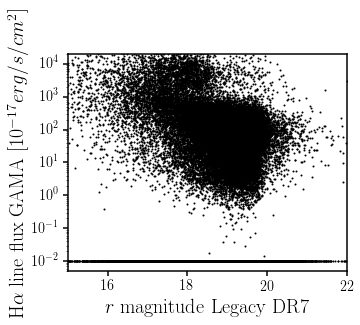

In [6]:
fig = plt.figure(figsize=(5, 4))
sub = fig.add_subplot(111)
hashalpha = (gama_ha > 0.)
sub.scatter(r_mag_legacy[hashalpha], gama_ha[hashalpha], c='k', s=1)
sub.scatter(r_mag_legacy[~hashalpha], np.repeat(1e-2, np.sum(~hashalpha)), c='k', s=1)
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'H$\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_yscale('log')
sub.set_ylim([5e-3, 2e4])

(0.005, 100000.0)

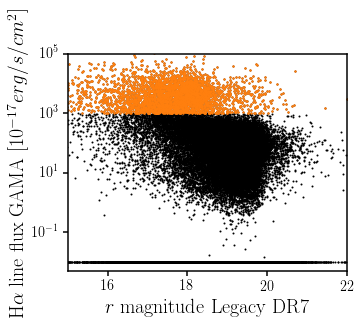

In [7]:
fig = plt.figure(figsize=(5, 4))
sub = fig.add_subplot(111)
hashalpha = (gama_ha > 0.)
sub.scatter(r_mag_legacy[hashalpha], gama_ha[hashalpha], c='k', s=1)
sub.scatter(r_mag_legacy[~hashalpha], np.repeat(1e-2, np.sum(~hashalpha)), c='k', s=1)

strong_ha = (gama_ha > 1e3)
sub.scatter(r_mag_legacy[strong_ha], gama_ha[strong_ha], c='C1', s=2)

sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'H$\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_yscale('log')
sub.set_ylim([5e-3, 1e5])

In [8]:
vdisp = np.repeat(100., ngal)
# calculate source spectra from templates
s_bgs = FM.BGSsourceSpectra(wavemin=1200., wavemax=12000.)

INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits


In [9]:
# emission lines from GAMA
emline_flux = s_bgs.EmissionLineFlux(gleg, index=np.arange(ngal)[strong_ha], dr_gama=3, silent=True)

In [10]:
flux_eml, wave, _, magnorm_flag = s_bgs.Spectra(r_mag_apflux[strong_ha], redshift[strong_ha],
                                  vdisp[strong_ha], seed=1, templateid=match[strong_ha],
                                  emflux=emline_flux, mag_em=r_mag_gama[strong_ha], silent=False)

--------------------
the 5 th galaxy has brighter emission lines than photometry...
--------------------
the 51 th galaxy has brighter emission lines than photometry...
--------------------
the 52 th galaxy has brighter emission lines than photometry...
--------------------
the 61 th galaxy has brighter emission lines than photometry...
--------------------
the 63 th galaxy has brighter emission lines than photometry...
--------------------
the 70 th galaxy has brighter emission lines than photometry...
--------------------
the 118 th galaxy has brighter emission lines than photometry...
--------------------
the 134 th galaxy has brighter emission lines than photometry...
--------------------
the 140 th galaxy has brighter emission lines than photometry...
--------------------
the 148 th galaxy has brighter emission lines than photometry...
--------------------
the 167 th galaxy has brighter emission lines than photometry...
--------------------
the 168 th galaxy has brighter emission 

--------------------
the 2816 th galaxy has brighter emission lines than photometry...
--------------------
the 2839 th galaxy has brighter emission lines than photometry...
--------------------
the 2854 th galaxy has brighter emission lines than photometry...
--------------------
the 2857 th galaxy has brighter emission lines than photometry...
--------------------
the 2867 th galaxy has brighter emission lines than photometry...
--------------------
the 2896 th galaxy has brighter emission lines than photometry...
--------------------
the 2899 th galaxy has brighter emission lines than photometry...
--------------------
the 2930 th galaxy has brighter emission lines than photometry...
--------------------
the 2934 th galaxy has brighter emission lines than photometry...
--------------------
the 2936 th galaxy has brighter emission lines than photometry...
--------------------
the 2938 th galaxy has brighter emission lines than photometry...
--------------------
the 2946 th galaxy has

(0.005, 100000.0)

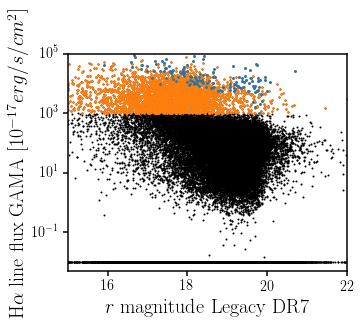

In [11]:
fig = plt.figure(figsize=(5, 4))
sub = fig.add_subplot(111)
hashalpha = (gama_ha > 0.)
sub.scatter(r_mag_legacy[hashalpha], gama_ha[hashalpha], c='k', s=1)
sub.scatter(r_mag_legacy[~hashalpha], np.repeat(1e-2, np.sum(~hashalpha)), c='k', s=1)

strong_ha = (gama_ha > 1e3)
sub.scatter(r_mag_legacy[strong_ha], gama_ha[strong_ha], c='C1', s=2)

strong_ha_magnorm_flag = np.arange(ngal)[strong_ha][~magnorm_flag]
sub.scatter(r_mag_legacy[strong_ha_magnorm_flag], gama_ha[strong_ha_magnorm_flag], c='C0', s=3)

sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'H$\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_yscale('log')
sub.set_ylim([5e-3, 1e5])

(15.0, 22.0)

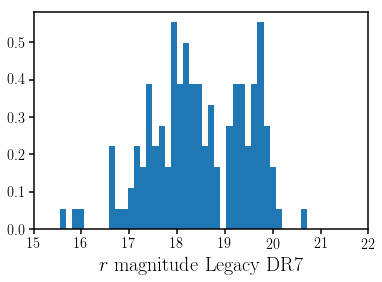

In [20]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(r_mag_legacy[strong_ha_magnorm_flag], density=True, bins=40)
sub.set_xlabel('$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])

The $r$ magnitude distribution of objects that have GAMA emission line measurements that are brighter than its photometry. Perhaps unsurprisingly, these objects are faint with strong emission lines. It's unclearly how this affects the redshift success rate at the moment. 